<a href="https://colab.research.google.com/github/mrittika-dey/NMA_Emoti-Conn/blob/main/Copy_of_load_hcp_task_with_behaviour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load HCP parcellated task data 
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
# @title Install dependencies
!pip install nilearn --quiet

     |████████████████████████████████| 9.6 MB 19.6 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [ ]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [ ]:
region_info['name']

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task. 

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [ ]:
my_exp = 'EMOTION'
my_subj = subjects[0]
my_run = 0

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

(360, 176)


As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

In [ ]:
evs

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions. 

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [ ]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx])-1)], axis=-1), axis=1)


fear_activity = average_frames(data, evs, my_exp, 'fear')
neut_activity = average_frames(data, evs, my_exp, 'neut')
contrast = fear_activity - neut_activity  # difference between left and right hand movement

In [ ]:
fear_activity.shape

In [ ]:
my_exp = 'EMOTION'

def fetch_emotional_data(my_subj,my_run):
 
    data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
    return np.concatenate((data[:, evs[0][0]],data[:,evs[0][1]]),axis=1)


concatenated_matrix_emotional=np.dstack((fetch_emotional_data(subjects[0],0),fetch_emotional_data(subjects[0],1)))

for my_subj in range(1,100):
  for my_run in range(2):
    concatenated_matrix_emotional=np.dstack((concatenated_matrix_emotional,fetch_emotional_data(subjects[my_subj],my_run)))
  


In [ ]:
concatenated_matrix_emotional.shape

(360, 50, 200)

In [ ]:
my_exp = 'EMOTION'

def fetch_neutral_data(my_subj,my_run):
 
    data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
    return np.concatenate((data[:, evs[1][0]],data[:,evs[1][1]]),axis=1)


concatenated_matrix_neutral=np.dstack((fetch_neutral_data(subjects[0],0),fetch_neutral_data(subjects[0],1)))

for my_subj in range(1,100):
  for my_run in range(2):
    concatenated_matrix_neutral=np.dstack((concatenated_matrix_neutral,fetch_neutral_data(subjects[my_subj],my_run)))

In [ ]:
concatenated_matrix_neutral.shape

(360, 50, 200)

In [ ]:
ROI_mean_Emotional=np.mean(concatenated_matrix_emotional,axis=2)
#ROI_mean_Emotional
ROI_mean_Emotional.shape

(360, 50)

In [ ]:
ROI_mean_Neutral=np.mean(concatenated_matrix_neutral,axis=2)
ROI_mean_Neutral.shape
#ROI_mean_Neutral.shape

(360, 50)

In [ ]:
from scipy.stats import pearsonr

for ROI1 in range(0,360):
  
  
  for ROI2 in range(0,360):
      if ROI2 == 0:

       corr_emotional, _= pearsonr(ROI_mean_Emotional[ROI1,:],ROI_mean_Emotional[0,:])
       corr_emotional_array=np.array(corr_emotional)

      else:
    
       corr_emotional, _= pearsonr(ROI_mean_Emotional[ROI1,:],ROI_mean_Emotional[ROI2,:])
       corr_emotional_array=np.append(corr_emotional_array,np.array(corr_emotional))
  
  if ROI1==0:
    corr_emotional_array_rows=corr_emotional_array 
    #break
  else: 
    corr_emotional_array_rows=np.vstack((corr_emotional_array_rows,corr_emotional_array))
   
  




In [ ]:
#from scipy.stats import pearsonr

for ROI1 in range(0,360):
  
  
  for ROI2 in range(0,360):
      if ROI2 == 0:

       corr_neutral, _= pearsonr(ROI_mean_Neutral[ROI1,:],ROI_mean_Neutral[0,:])
       corr_neutral_array=np.array(corr_neutral)

      else:
    
       corr_neutral, _= pearsonr(ROI_mean_Neutral[ROI1,:],ROI_mean_Neutral[ROI2,:])
       corr_neutral_array=np.append(corr_neutral_array,np.array(corr_neutral))
  
  if ROI1==0:
    corr_neutral_array_rows=corr_neutral_array 
  else: 
    corr_neutral_array_rows=np.vstack((corr_neutral_array_rows,corr_neutral_array))

In [ ]:
our_desired_rois_R_indexes=[25,56,57,58,59,60,61,62,63,64,66,67,68,69,70,72,82,83,84,85,86,87,96,97,102,105,108,110,111,119,163,164,166,167,177,178,179]
our_desired_rois_l_indexes=[205,236,237,238,239,240,241,242,243,244,246,247,248,249,250,252,262,263,264,265,266,267,276,277,282,285,288,290,291,299,343,344,346,347,357,358,359]
our_desired_rois_R=[region_info['name'][i]  for i in our_desired_rois_R_indexes]
our_desired_rois_l=[region_info['name'][i]  for i in our_desired_rois_l_indexes]

In [ ]:
our_desired_rois_l

['L_SFL',
 'L_p24pr',
 'L_33pr',
 'L_a24pr',
 'L_p32pr',
 'L_a24',
 'L_d32',
 'L_8BM',
 'L_p32',
 'L_10r',
 'L_8Av',
 'L_8Ad',
 'L_9m',
 'L_8BL',
 'L_9p',
 'L_8C',
 'L_p9-46v',
 'L_46',
 'L_a9-46v',
 'L_9-46d',
 'L_9a',
 'L_10v',
 'L_i6-8',
 'L_s6-8',
 'L_52',
 'L_PoI2',
 'L_MI',
 'L_AVI',
 'L_AAIC',
 'L_H',
 'L_25',
 'L_s32',
 'L_PoI1',
 'L_Ig',
 'L_PI',
 'L_a32pr',
 'L_p24']

In [ ]:
ROI_mean_Emotional_Right=ROI_mean_Emotional[our_desired_rois_R_indexes]
ROI_mean_Emotional_Left=ROI_mean_Emotional[our_desired_rois_l_indexes]
ROI_mean_Neutral_Right=ROI_mean_Neutral[our_desired_rois_R_indexes]
ROI_mean_Neutral_Left=ROI_mean_Neutral[our_desired_rois_l_indexes]

In [ ]:
ROI_mean_Emotional_Right.shape

(37, 50)

In [ ]:
from scipy.stats import pearsonr

for ROI1 in range(0,37):
  
  
  for ROI2 in range(0,37):
      if ROI2 == 0:

       corr_emotional_Right, _= pearsonr(ROI_mean_Emotional_Right[ROI1,:],ROI_mean_Emotional_Right[0,:])
       corr_emotional_array_Right=np.array(corr_emotional_Right)

      else:
    
       corr_emotional_Right, _= pearsonr(ROI_mean_Emotional_Right[ROI1,:],ROI_mean_Emotional_Right[ROI2,:])
       corr_emotional_array_Right=np.append(corr_emotional_array_Right,np.array(corr_emotional_Right))
  
  if ROI1==0:
    corr_emotional_array_rows_Right=corr_emotional_array_Right
  else: 
    corr_emotional_array_rows_Right=np.vstack((corr_emotional_array_rows_Right,corr_emotional_array_Right))

In [ ]:
from scipy.stats import pearsonr

for ROI1 in range(0,37):
  
  
  for ROI2 in range(0,37):
      if ROI2 == 0:

       corr_emotional_Left, _= pearsonr(ROI_mean_Emotional_Left[ROI1,:],ROI_mean_Emotional_Left[0,:])
       corr_emotional_array_Left=np.array(corr_emotional_Left)

      else:
    
       corr_emotional_Left, _= pearsonr(ROI_mean_Emotional_Left[ROI1,:],ROI_mean_Emotional_Left[ROI2,:])
       corr_emotional_array_Left=np.append(corr_emotional_array_Left,np.array(corr_emotional_Left))
  
  if ROI1==0:
    corr_emotional_array_rows_Left=corr_emotional_array_Left 
  else: 
    corr_emotional_array_rows_Left=np.vstack((corr_emotional_array_rows_Left,corr_emotional_array_Left))

In [ ]:
for ROI1 in range(0,37):
  
  
  for ROI2 in range(0,37):
      if ROI2 == 0:

       corr_neutral_Right, _= pearsonr(ROI_mean_Neutral_Right[ROI1,:],ROI_mean_Neutral_Right[0,:])
       corr_neutral_array_Right=np.array(corr_neutral_Right)

      else:
    
       corr_neutral_Right, _= pearsonr(ROI_mean_Neutral_Right[ROI1,:],ROI_mean_Neutral_Right[ROI2,:])
       corr_neutral_array_Right=np.append(corr_neutral_array_Right,np.array(corr_neutral_Right))
  
  if ROI1==0:
    corr_neutral_array_rows_Right=corr_neutral_array_Right
  else: 
    corr_neutral_array_rows_Right=np.vstack((corr_neutral_array_rows_Right,corr_neutral_array_Right))

In [ ]:
for ROI1 in range(0,37):
  
  
  for ROI2 in range(0,37):
      if ROI2 == 0:

       corr_neutral_Left, _= pearsonr(ROI_mean_Neutral_Left[ROI1,:],ROI_mean_Neutral_Left[0,:])
       corr_neutral_array_Left=np.array(corr_neutral_Left)

      else:
    
       corr_neutral_Left, _= pearsonr(ROI_mean_Neutral_Left[ROI1,:],ROI_mean_Neutral_Left[ROI2,:])
       corr_neutral_array_Left=np.append(corr_neutral_array_Left,np.array(corr_neutral_Left))
  
  if ROI1==0:
    corr_neutral_array_rows_Left=corr_neutral_array_Left
  else: 
    corr_neutral_array_rows_Left=np.vstack((corr_neutral_array_rows_Left,corr_neutral_array_Left))

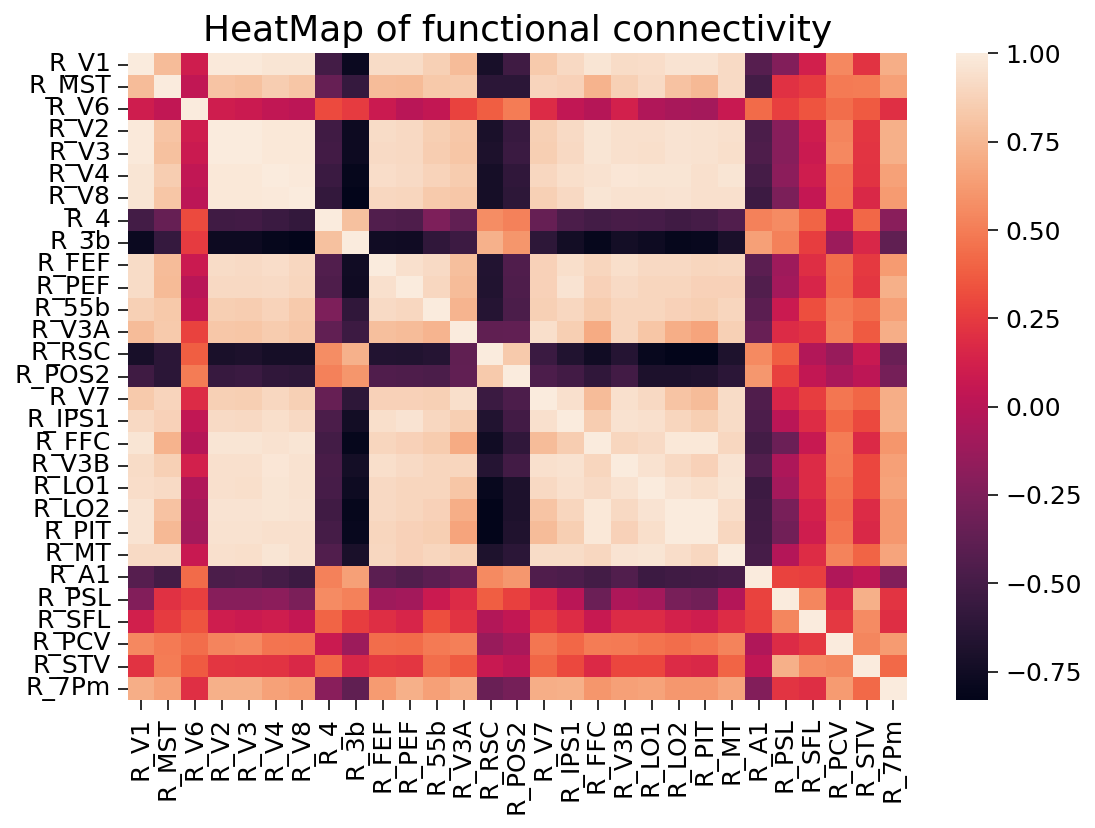

In [ ]:
#  Plot the heatmap
import seaborn as sns
corr_emotional_array_rows=np.asarray(corr_emotional_array_rows,'float16')
plt.figure()
heat_map = sns.heatmap(corr_emotional_array_rows[0:29,0:29], annot = False,xticklabels=region_info['name'][0:29], yticklabels=region_info['name'][0:29])
plt.title( "HeatMap of functional connectivity" )
plt.show()
fig = heat_map.get_figure()
fig.savefig('Heatmap.png')

In [ ]:
plt.savefig('output.png')

<Figure size 576x432 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


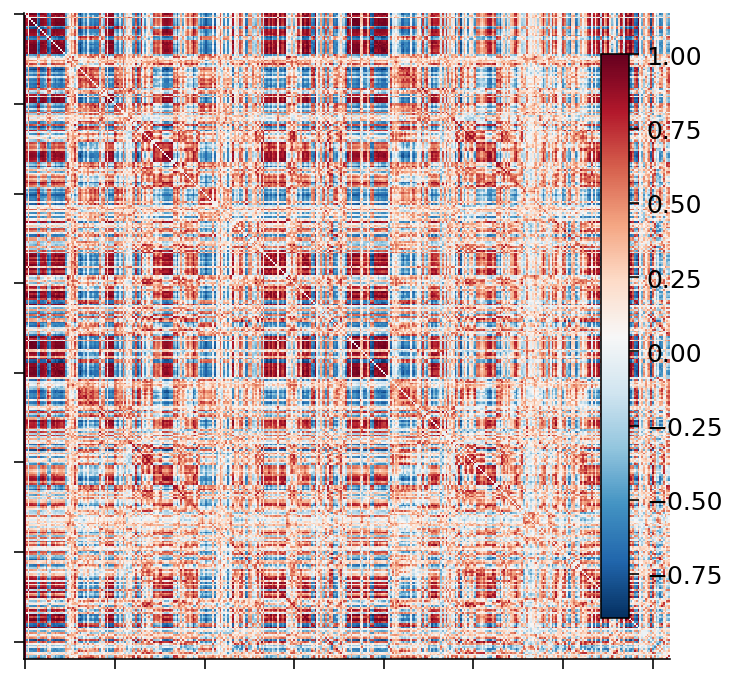

In [ ]:
# import numpy as np
# from nilearn import plotting
# corr_emotional_array_rows=np.asarray(corr_emotional_array_rows,'float32')
# np.fill_diagonal(corr_emotional_array_rows, 0)
# plotting.plot_matrix(corr_emotional_array_rows)



Dataset created in /root/nilearn_data/msdl_atlas



 ...done. (0 seconds, 0 min)
Extracting data from /root/nilearn_data/msdl_atlas/5d25e157f36214b8ca9a12fd417aac1c/MSDL_rois.zip..... done.
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


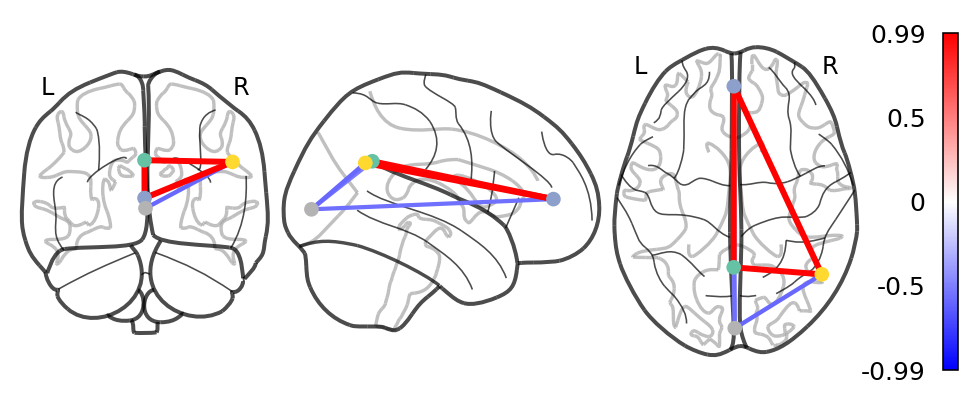

In [ ]:
from nilearn import plotting
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
labels = atlas['labels']
coords = atlas.region_coords[4:8]

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
# plotting.plot_connectome(corr_emotional_array_rows[4:8,4:8], coords, colorbar=True,node_size=40,output_file='Glass.png')
plotting.plot_connectome(corr_emotional_array_rows[4:8,4:8], coords, colorbar=True,node_size=40)
plotting.show()


In [ ]:
our_desired_rois_R_indexes=[25,56,57,58,59,60,61,62,63,64,66,67,68,69,70,72,82,83,84,85,86,87,96,97,102,105,108,110,111,119,163,164,166,167,177,178,179]
our_desired_rois_l_indexes=[205,236,237,238,239,240,241,242,243,244,246,247,248,249,250,252,262,263,264,265,266,267,276,277,282,285,288,290,291,299,343,344,346,347,357,358,359]
our_desired_rois_R=[region_info['name'][i]  for i in our_desired_rois_R_indexes]
our_desired_rois_l=[region_info['name'][i]  for i in our_desired_rois_l_indexes]

In [ ]:
from scipy.stats import pearsonr

for ROI1 in range(0,37):
  
  
  for ROI2 in range(0,37):
      if ROI2 == 0:

       corr_emotional_Right, _= pearsonr(ROI_mean_Emotional_Right[ROI1,:],ROI_mean_Emotional_Right[0,:])
       corr_emotional_array_Right=np.array(corr_emotional_Right)

      else:
    
       corr_emotional_Right, _= pearsonr(ROI_mean_Emotional_Right[ROI1,:],ROI_mean_Emotional_Right[ROI2,:])
       corr_emotional_array_Right=np.append(corr_emotional_array_Right,np.array(corr_emotional_Right))
  
  if ROI1==0:
    corr_emotional_array_rows_Right=corr_emotional_array_Right
  else: 
    corr_emotional_array_rows_Right=np.vstack((corr_emotional_array_rows_Right,corr_emotional_array_Right))

In [ ]:
from scipy.stats import pearsonr

for ROI1 in range(0,37):
  
  
  for ROI2 in range(0,37):
      if ROI2 == 0:

       corr_emotional_Left, _= pearsonr(ROI_mean_Emotional_Left[ROI1,:],ROI_mean_Emotional_Left[0,:])
       corr_emotional_array_Left=np.array(corr_emotional_Left)

      else:
    
       corr_emotional_Left, _= pearsonr(ROI_mean_Emotional_Left[ROI1,:],ROI_mean_Emotional_Left[ROI2,:])
       corr_emotional_array_Left=np.append(corr_emotional_array_Left,np.array(corr_emotional_Left))
  
  if ROI1==0:
    corr_emotional_array_rows_Left=corr_emotional_array_Left 
  else: 
    corr_emotional_array_rows_Left=np.vstack((corr_emotional_array_rows_Left,corr_emotional_array_Left))

In [ ]:
for ROI1 in range(0,37):
  
  
  for ROI2 in range(0,37):
      if ROI2 == 0:

       corr_neutral_Right, _= pearsonr(ROI_mean_Neutral_Right[ROI1,:],ROI_mean_Neutral_Right[0,:])
       corr_neutral_array_Right=np.array(corr_neutral_Right)

      else:
    
       corr_neutral_Right, _= pearsonr(ROI_mean_Neutral_Right[ROI1,:],ROI_mean_Neutral_Right[ROI2,:])
       corr_neutral_array_Right=np.append(corr_neutral_array_Right,np.array(corr_neutral_Right))
  
  if ROI1==0:
    corr_neutral_array_rows_Right=corr_neutral_array_Right
  else: 
    corr_neutral_array_rows_Right=np.vstack((corr_neutral_array_rows_Right,corr_neutral_array_Right))

In [ ]:
for ROI1 in range(0,37):
  
  
  for ROI2 in range(0,37):
      if ROI2 == 0:

       corr_neutral_Left, _= pearsonr(ROI_mean_Neutral_Left[ROI1,:],ROI_mean_Neutral_Left[0,:])
       corr_neutral_array_Left=np.array(corr_neutral_Left)

      else:
    
       corr_neutral_Left, _= pearsonr(ROI_mean_Neutral_Left[ROI1,:],ROI_mean_Neutral_Left[ROI2,:])
       corr_neutral_array_Left=np.append(corr_neutral_array_Left,np.array(corr_neutral_Left))
  
  if ROI1==0:
    corr_neutral_array_rows_Left=corr_neutral_array_Left
  else: 
    corr_neutral_array_rows_Left=np.vstack((corr_neutral_array_rows_Left,corr_neutral_array_Left))

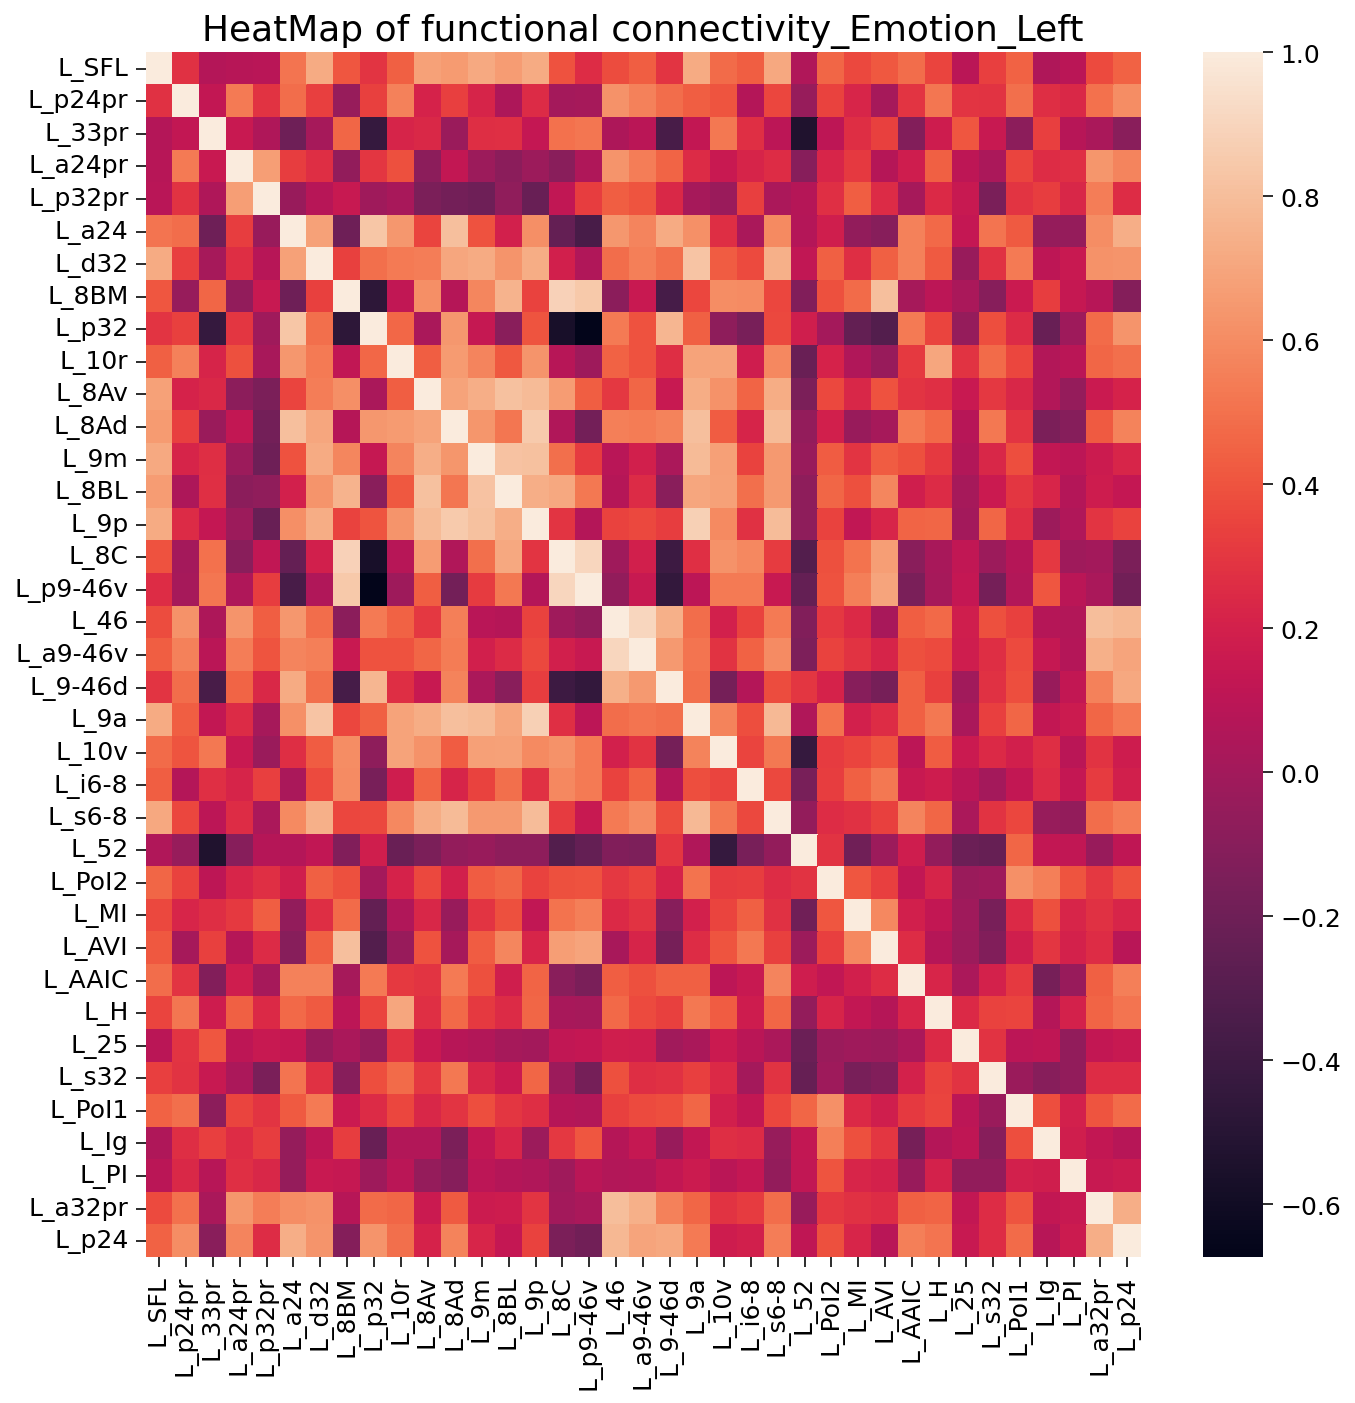

In [ ]:
our_desired_rois_indexes=our_desired_rois_R_indexes+our_desired_rois_l_indexes

ROI_mean_Emotional_Right=ROI_mean_Emotional[our_desired_rois_R_indexes]
ROI_mean_Emotional_Left=ROI_mean_Emotional[our_desired_rois_l_indexes]
ROI_mean_Neutral_Right=ROI_mean_Neutral[our_desired_rois_R_indexes]
ROI_mean_Neutral_Left=ROI_mean_Neutral[our_desired_rois_l_indexes]
#......................................................
import seaborn as sns
corr_emotional_array_rows_Right=np.asarray(corr_emotional_array_rows_Right,'float16')
corr_emotional_array_rows_Left=np.asarray(corr_emotional_array_rows_Left,'float16')
corr_neutral_array_rows_Right=np.asarray(corr_neutral_array_rows_Right,'float16')
corr_neutral_array_rows_Left=np.asarray(corr_neutral_array_rows_Left,'float16')
plt.figure(figsize=(10,10))
plt.tight_layout()
# our_desired_FonctionalConnectivity_Emotion_Right=sns.heatmap(corr_emotional_array_rows_Right, annot = False,xticklabels=our_desired_rois_R, yticklabels=our_desired_rois_R)
our_desired_FonctionalConnectivity_Emotion_Left=sns.heatmap(corr_emotional_array_rows_Left, annot = False,xticklabels=our_desired_rois_l, yticklabels=our_desired_rois_l)
# our_desired_FonctionalConnectivity_Neutral_Right=sns.heatmap(corr_neutral_array_rows_Right, annot = False,xticklabels=our_desired_rois_R, yticklabels=our_desired_rois_R)
# our_desired_FonctionalConnectivity_Neutral_Left=sns.heatmap(corr_neutral_array_rows_Left, annot = False,xticklabels=our_desired_rois_l, yticklabels=our_desired_rois_l)
plt.title( "HeatMap of functional connectivity_Emotion_Left" )
fig = our_desired_FonctionalConnectivity_Emotion_Left.get_figure()
plt.tight_layout()
plt.show()



In [ ]:
corr_emotional_array_rows_Right=np.asarray(corr_emotional_array_rows_Right,'float16')
corr_emotional_array_rows_Left=np.asarray(corr_emotional_array_rows_Left,'float16')
corr_neutral_array_rows_Right=np.asarray(corr_neutral_array_rows_Right,'float16')
corr_neutral_array_rows_Left=np.asarray(corr_neutral_array_rows_Left,'float16')

In [ ]:
np.save("NeutralLeft",corr_neutral_array_rows_Left)

In [ ]:
np.save('corr_neutral_array_rows_Left',corr_neutral_array_rows_Left)

In [ ]:
fig.savefig('Heatmap_Emotion_Left.png')


In [ ]:
corr_emotional_array_rows_Right.shape
our_desired_rois_R
np.save('CorralationMatrix',corr_emotional_array_rows_Right)
np.save('Right_regions',our_desired_rois_R)

In [ ]:
import seaborn as sns
corr_emotional_array_rows=np.asarray(corr_emotional_array_rows,'float16')
plt.figure()
heat_map = sns.heatmap(corr_emotional_array_rows[0:29,0:29], annot = False,xticklabels=region_info['name'][0:29], yticklabels=region_info['name'][0:29])
plt.title( "HeatMap of functional connectivity" )
plt.show()
fig = heat_map.get_figure()
fig.savefig('Heatmap.png')

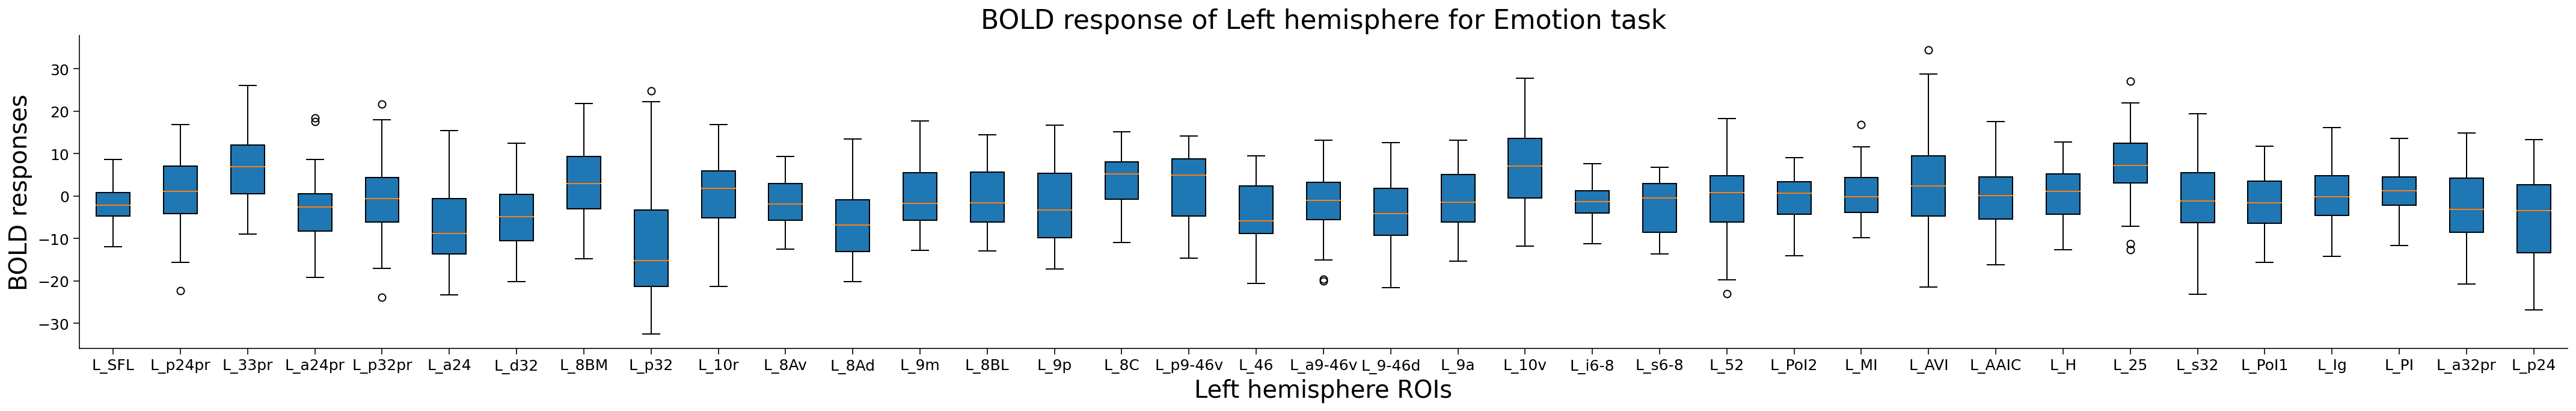

In [ ]:
# our_desired_rois_R
# our_desired_rois_l
import matplotlib
fig, ax = plt.subplots(figsize=(30, 5))

Bold_Emotion_Right=np.rot90(ROI_mean_Emotional_Right)
Bold_Emotion_Left=np.rot90(ROI_mean_Emotional_Left)
Bold_Neutral_Right=np.rot90(ROI_mean_Neutral_Right)
Bold_Neutral_Left=np.rot90(ROI_mean_Neutral_Left)
ax.boxplot(Bold_Emotion_Left,patch_artist = True) 
ax.set_xticklabels(our_desired_rois_l)
ax.set_title('BOLD response of Left hemisphere for Emotion task',fontsize=22)
ax.set_xlabel('Left hemisphere ROIs',fontsize=20)
ax.set_ylabel('BOLD responses',fontsize=20)
fig.savefig('Boxplot_Emotion_Left.png')

In [ ]:
our_desired_rois_R

['R_SFL',
 'R_p24pr',
 'R_33pr',
 'R_a24pr',
 'R_p32pr',
 'R_a24',
 'R_d32',
 'R_8BM',
 'R_p32',
 'R_10r',
 'R_8Av',
 'R_8Ad',
 'R_9m',
 'R_8BL',
 'R_9p',
 'R_8C',
 'R_p9-46v',
 'R_46',
 'R_a9-46v',
 'R_9-46d',
 'R_9a',
 'R_10v',
 'R_i6-8',
 'R_s6-8',
 'R_52',
 'R_PoI2',
 'R_MI',
 'R_AVI',
 'R_AAIC',
 'R_H',
 'R_25',
 'R_s32',
 'R_PoI1',
 'R_Ig',
 'R_PI',
 'R_a32pr',
 'R_p24']

In [ ]:
#from scipy.stats import pearsonr

for ROI1 in range(0,360):
  
  
  for ROI2 in range(0,360):
      if ROI2 == 0:

       corr_neutral, _= pearsonr(ROI_mean_Neutral[0,:],ROI_mean_Neutral[0,:])
       corr_neutral_array=np.array(corr_neutral)

      else:
    
       corr_neutral, _= pearsonr(ROI_mean_Neutral[ROI1,:],ROI_mean_Neutral[ROI2,:])
       corr_neutral_array=np.append(corr_neutral_array,np.array(corr_neutral))
  
  if ROI1==0:
    corr_neutral_array_rows=corr_neutral_array 
  else: 
    corr_neutral_array_rows=np.vstack((corr_neutral_array_rows,corr_neutral_array))
    
  

In [ ]:
corr_neutral_array_rows.shape

In [ ]:
evs

In [ ]:
for my_subj in range(100):
  for my_run in range(2):
    evs_check = load_evs(subject=subjects[my_subj], experiment=my_exp, run=my_run)

    if np.array_equal(evs_check[0][0],evs[0][0])==False:
      print("EVS not same",evs_check)

In [ ]:
for my_subj in range(100):
  for my_run in range(2):
    evs_check = load_evs(subject=subjects[my_subj], experiment=my_exp, run=my_run)

    if np.array_equal(evs_check[0][1],evs[0][1])==False:
      print("EVS not same",evs_check)

In [ ]:
for my_subj in range(100):
  for my_run in range(2):
    evs_check = load_evs(subject=subjects[my_subj], experiment=my_exp, run=my_run)

    if np.array_equal(evs_check[1][0],evs[1][0])==False:
      print("EVS not same",evs_check)

In [ ]:
for my_subj in range(100):
  for my_run in range(2):
    evs_check = load_evs(subject=subjects[my_subj], experiment=my_exp, run=my_run)

    if np.array_equal(evs_check[1][1],evs[1][1])==False:
      print("EVS not same",evs_check[1][1])

In [ ]:
evs[1][1]

In [ ]:
# we need a little function that averages all frames from any given condition

def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx])-1)], axis=-1), axis=1)


fear_activity = average_frames(data, evs, my_exp, 'fear')
neut_activity = average_frames(data, evs, my_exp, 'neut')
contrast = fear_activity - neut_activity  # difference between left and right hand movement

In [ ]:
# Plot activity level in each ROI for both conditions
plt.plot(lf_activity,label='fear')
plt.plot(rf_activity,label='neut')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





In [ ]:
df = pd.DataFrame({'lf_activity' : lf_activity,
                   'rf_activity' : rf_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='lf_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='rf_activity', data=df, hue='hemi',ax=ax2)
plt.show()

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans). 


Let us boost thee stats by averaging across all subjects and runs. 

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    lf_activity = average_frames(data, evs, my_exp, 'lf')
    rf_activity = average_frames(data, evs, my_exp, 'rf')

    contrast = lf_activity - rf_activity
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

In [ ]:
df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

In [ ]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

NameError: ignored